In [ ]:
import numpy as np
import matplotlib.pyplot as plt


class ContinuousSignal:
    def __init__(self, func):
        self.func = func

    def get_value_at_time(self, time):
        # Get the value of the signal at a specific time
        return self.func(time)

    def add(self, other):
        # Define a method to add another signal to this one
        def add_func(x):
            return self.func(x) + other.func(x)
        new_signal = ContinuousSignal(add_func)
        return new_signal

    def shift_signal(self, shift):
        # Define a method to shift the signal by a specific amount
        def shifted_func(x):
            return self.func(x - shift)
        new_signal = ContinuousSignal(shifted_func)
        return new_signal

    def multiply(self, other):
        # Define a method to multiply this signal with another
        def multiplied_func(x):
            return self.func(x) * other.func(x)
        new_signal = ContinuousSignal(multiplied_func)
        return new_signal

    def multiply_const_factor(self, scaler):
        # Define a method to multiply the signal by a scalar factor
        def scaled_func(x):
            return self.func(x) * scaler
        new_signal = ContinuousSignal(scaled_func)
        return new_signal

    def plot(self, start, end, label):
        # Generate the x values for plotting
        x = np.linspace(start, end, 1000)
        # Get the corresponding y values by applying the signal function
        y = self.func(x)
        
        # Plot the signal with a label
        plt.plot(x, y, label=label)
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.grid(True)

    @staticmethod
    def show():
        # Show all the plots
        plt.legend()
        plt.show()

# Define the unit impulse function separately
def unit_impulse(x):
    delta = 0.05
    impulse = np.zeros_like(x)  # Create an array of zeros with the same shape as x
    impulse[(x >= 0) & (x < delta)] = 1 / delta  # Set the impulse value where the condition is met
    return impulse


def unit_step(x):
    return np.where(x >= 0, 1, 0)

contSig=ContinuousSignal(unit_step)
contSig.plot(-10,10,'unit step')
contSig2=contSig.shift_signal(3)
contSig2.plot(-10,10,'unit step shifted by 3')

ValueError: Number of rows must be a positive integer, not 0

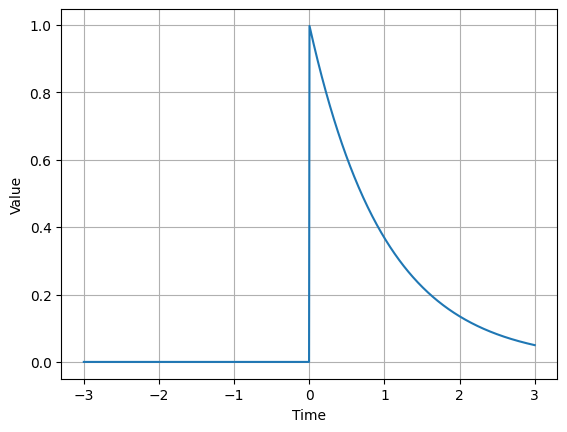

<Figure size 640x480 with 0 Axes>

<Figure size 1600x0 with 0 Axes>

In [9]:
import os
class LTI_Continuous:
    def __init__(self, impulse_response):
        self.impulse_response = impulse_response
        self.INF = -3

    def linear_combination_of_impulses(self, input_signal, delta):
        decomposed = []
        components = []
        shifts = []
        for i in np.arange(-self.INF, self.INF + 1, delta):
            coefficient = input_signal.get_value_at_time(i)

            # Create unit impulse
            impulse = ContinuousSignal(unit_impulse)
            # Shift the impulse by i amount
            shiftedImpulse = impulse.shift_signal(i)
            
            components.append(shiftedImpulse.multiply_const_factor(coefficient))
            shifts.append(i)
            # Append the pair (shifted_unit_impulse, coeff) to decomposed
            decomposed.append((shiftedImpulse, coefficient, i))
            scaled_impulse = shiftedImpulse.multiply_const_factor(coefficient)
        self.plot_components_subplots(components, shifts, input_signal, 'decomposed',delta)
        return decomposed

    def zero(self, x):
        return 0

    def plot_components_subplots(self, components, shifts, final_output, fileName,delta):
        num_components = len(components)
        num_rows = (num_components + 4 - 1) // 4  # Ensure space for final output
        fig, axs = plt.subplots(num_rows, 4, figsize=(16, 4 * num_rows))
        axs = axs.flatten()  # Flatten to handle indexing easily

        for idx, (component, time_shift) in enumerate(zip(components, shifts)):
            time_points = np.arange(-self.INF, self.INF + 1, delta)
            y=component.func(time_points)
          
            axs[idx].plot(time_points, y, label=r'$\delta(t - (%.1f)) \times x(%.1f)$' % (time_shift, time_shift))
            axs[idx].set_xlabel('t (Time Index)')
            axs[idx].set_ylabel('x(t)')
            axs[idx].set_ylim(0,1)  # Set y-axis limits from -1 to 6
            axs[idx].legend()
            axs[idx].grid(True)

        # Plot the final output (sum) in the next subplot
        time_points = np.arange(-self.INF, self.INF + 1, delta)
        
        y_final = final_output.func(time_points)
        axs[num_components].plot(time_points, y_final, label='Reconstructed Signal')
        axs[num_components].set_title('Reconstructed Signal')
        axs[num_components].set_xlabel('t (Time)')
        axs[num_components].set_ylabel('Amplitude')
        axs[num_components].legend()
        axs[num_components].grid(True)

        # Hide any unused subplots
        for j in range(num_components + 1, len(axs)):
            axs[j].axis('off')

        plt.tight_layout()
        if not os.path.exists("discrete_plots"):
            os.makedirs("discrete_plots")
        plt.savefig(f"cont_plots/{fileName}.png")
        plt.show()

    def output_approx(self, signal, delta):
        # Create a new continuous signal with all values set to 0
        result = ContinuousSignal(self.zero)

        # Decompose the input signal
        decomposed = self.linear_combination_of_impulses(signal, delta)
        
        components = []
        shifts=[]

        # For each decomposed signal, compute the output by shifting the impulse response and multiplying by the constant factor
        for decomposed_signal, coefficient, i in decomposed:
            response = self.impulse_response
            shifted_response = response.shift_signal(i)
            component = shifted_response.multiply_const_factor(coefficient)
            components.append(component)
            shifts.append(i)
            result = result.add(component)
            
        # Plot the components and the final output
        self.plot_components_subplots(components, shifts, result, 'output_approx',delta)
        return result

    def show(self):
        self.impulse_response.plot(-10, 10, 'Impulse Response')


def myFunc(x):
    return np.where(x > 0, np.exp(-x), 0)


def main():
    input_signal = ContinuousSignal(myFunc)
    input_signal.plot(-3, 3, "Input Signal")
    plt.savefig('cont_plots/input_signal.png')
    plt.figure()
    
    impulse_response = ContinuousSignal(unit_step)

    LTI_system = LTI_Continuous(impulse_response)
    
    output = LTI_system.output_approx(input_signal, 0.5)


main()
